# Vending Machine simulator

an effort to make a Monte-Carlo simulator for VM that will help to understand effect of different policies about product selection and refil strategy.

In [36]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from functools import partial

from vmSim import *
from strategies import FillUpAllExistingToMaxOnMinLevel
from optimizers import GridSearch

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Future considerations
- [ ] ML to find best strategy params
- [ ] ML to find best VM inventory within given constrains
- [ ] logic to cap number of VMs possible to refil during a day (how to choose which to refill?)
- [ ] map of locations (graph) with trasport costs b/w them for cost of trip estimate
- [ ] high level strategies: e.g. if one location is due for refill, then refill second in the same trip
- [ ] break downs?

# Some kind of introduction

In [4]:
# is a table with name and confidence interval of popularity
# popularity is just a number, it will later be normalized among all products, so relative is significant, not absolute
# log normal distribution is used to sample

products = {
    'coke': (50, 70),
    'beer': (10, 30),
    'water': (30, 50)
}

{'coke': 0.5199847699340836, 'beer': 0.1069932493171546, 'water': 0.37302198074876175}
[0.5199847699340836]


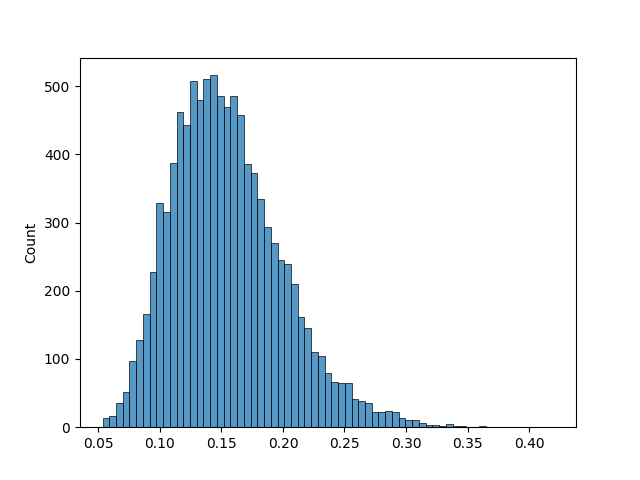

In [5]:
# example of Customer class
# it generates a random customer with preferences based on products popularity
c = Customer(products)
print(c.preferences)
print(c['coke'])

preferences = []
for _ in range(10_000):
    c = Customer(products)
    preferences.append(*c['beer'])
    
plt.figure()
sns.histplot(data=np.array(preferences))
plt.show()

In [6]:
local_time = SimulationTime() # basically a counter to keep things sync

In [7]:
# primary attribute of the location is it's traffic that may be random and given by confidence interval
l = Location('Sakh', traffic_conf_interval=(15, 30))
l.visits_today  # generates within confidence interval provided from lognormal distribution

25

In [11]:
# example of VendingMachine class
vm = VendingMachine(name='vm', location=l, time=local_time, columns=[
    ('coke', 10),
    ('coke', 10),
    ('beer', 10),
    ])
vm.refill({'coke': 15, 'beer': 20})
vm.available_products
vm.inventory, vm.capacity

(defaultdict(<function vmSim.VendingMachine.inventory.<locals>.<lambda>()>,
             {'coke': 15, 'beer': 10}),
 defaultdict(<function vmSim.VendingMachine.capacity.<locals>.<lambda>()>,
             {'coke': 20, 'beer': 10}))

# Refill strategies

In [37]:
class FillUpExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name: str, min_levels: dict[str, int], how_many_should_hit_min: int=1):
        self.name = name
        self.min_levels = min_levels
        self.how_many_should_hit_min = how_many_should_hit_min
    
    def make_refill_decision(self, vending_machine: VendingMachine) -> Decision:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision: Decision = {}
        for name, ammount in self.vm.inventory.items():
            if ammount < self.min_levels[name]:
                decision[name] = self.vm.capacity[name]
        if len(decision) < self.how_many_should_hit_min:
            decision = False
        return decision

# Simulation

## Set up

In [13]:
local_time = SimulationTime()

# -- Locations --

low_traffic_loc = Location('boring place', traffic_conf_interval=(3, 10))
high_traffic_loc = Location('railroad', traffic_conf_interval=(20, 40))

# -- Products --

PRODUCTS = pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('papa_beer', 40),
    ('water', 30),
    ('water', 30),
])

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('mama_beer', 40),
    ('baby_beer', 40),
    ('water', 30),
])


VMs = [vm1, vm2]

# -- Strategies -- 
s_topup_at_const = FillUpAllExistingToMaxOnMinLevel('top_at_10', min_levels={
    'papa_beer': 10,
    'mama_beer': 10,
    'baby_beer': 10,
    'water'    : 10,      
})
s_topup_at_var = FillUpAllExistingToMaxOnMinLevel('top_based_on_pop', min_levels={
    'papa_beer': 15,
    'mama_beer': 10,
    'baby_beer': 5,
    'water'    : 15,      
})

STGs = {
    vm1: s_topup_at_const,
    vm2: s_topup_at_const,
}

## Running cycle

In [15]:
sim = Simulation('test run',
                 products=PRODUCTS, 
                 VMs=VMs,
                 STGs=STGs,
                 cycles=50,
                 local_time=local_time)

sim.run()

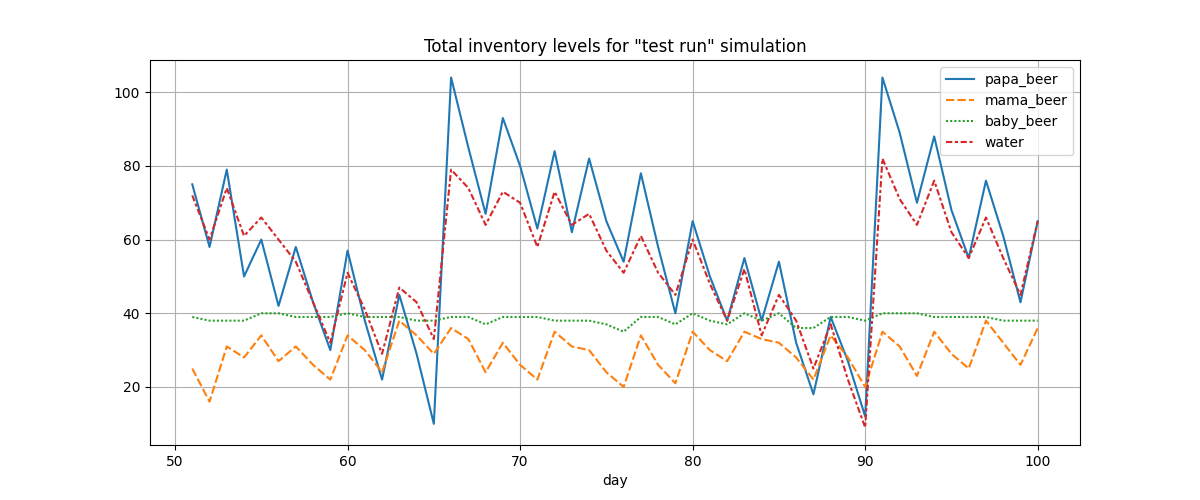

In [16]:
sim.plot_stat('total_inventory_levels')

Average inventory cost per day: 36,144.0 (sigma 7,980.7)


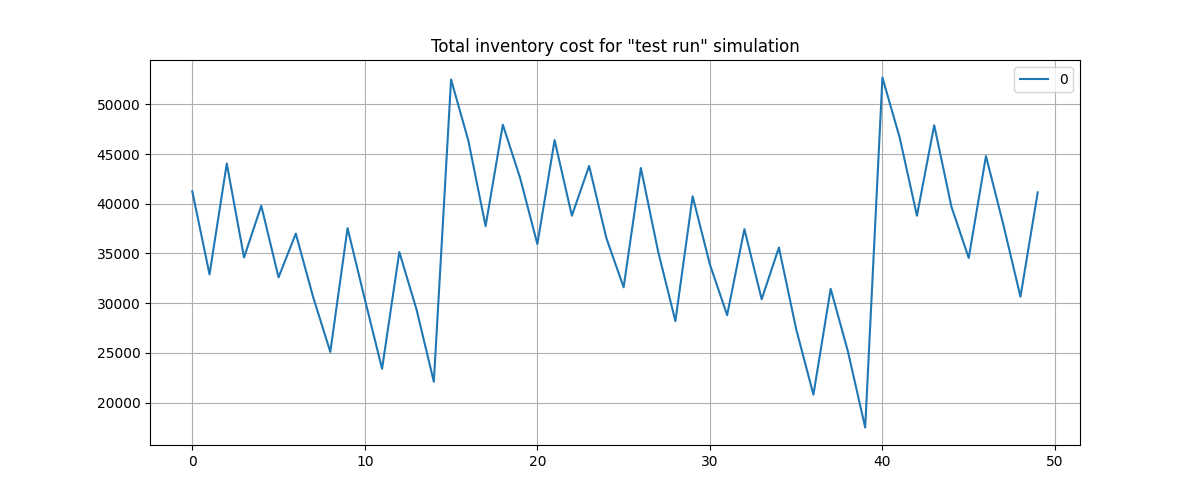

In [17]:
print(f'Average inventory cost per day: {np.mean(sim.total_inventory_cost):,.1f} (sigma {np.std(sim.total_inventory_cost):,.1f})')
sim.plot_stat('total_inventory_cost')

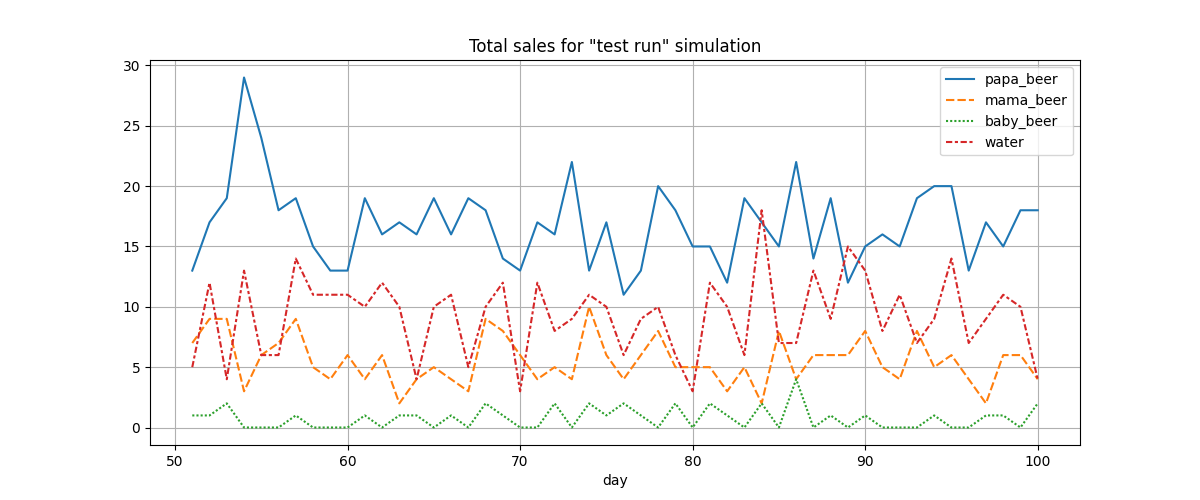

In [18]:
sim.plot_stat('total_sales')

Total sold outs for simulations: 23


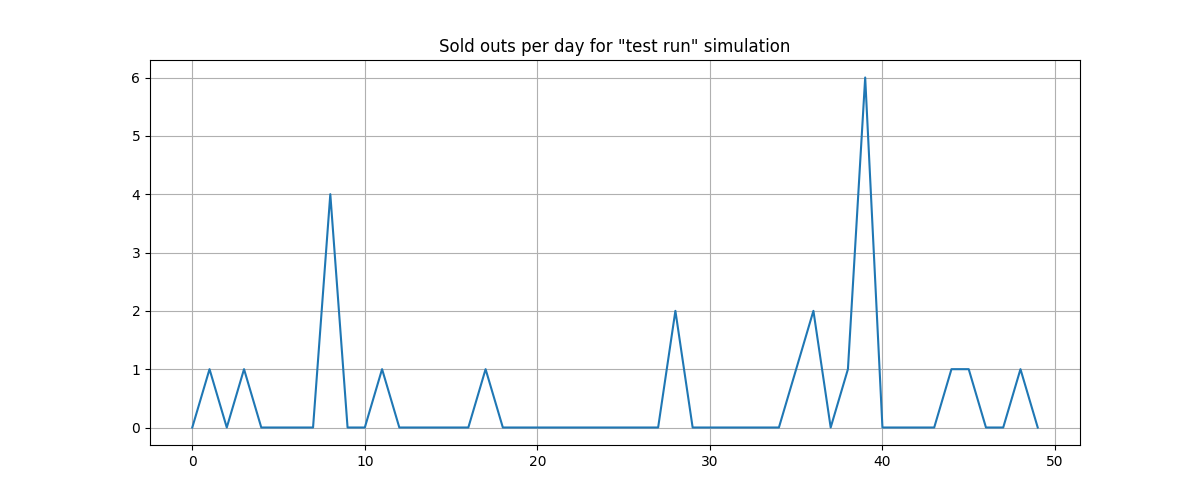

In [19]:
print(f'Total sold outs for simulations: {sum(sim.sold_outs_per_day)}')
sim.plot_stat('sold_outs_per_day')

Average profit per day: 2306.0 (sigma 355.3)


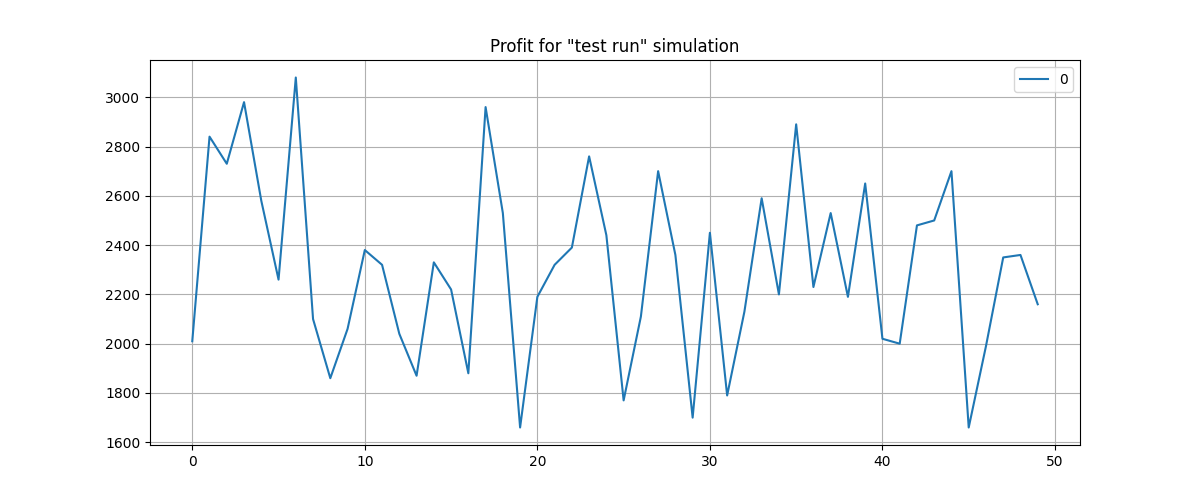

In [20]:
print(f'Average profit per day: {np.mean(sim.profit):.1f} (sigma {np.std(sim.profit):.1f})')
sim.plot_stat('profit')

Total top ups for simulations: 20


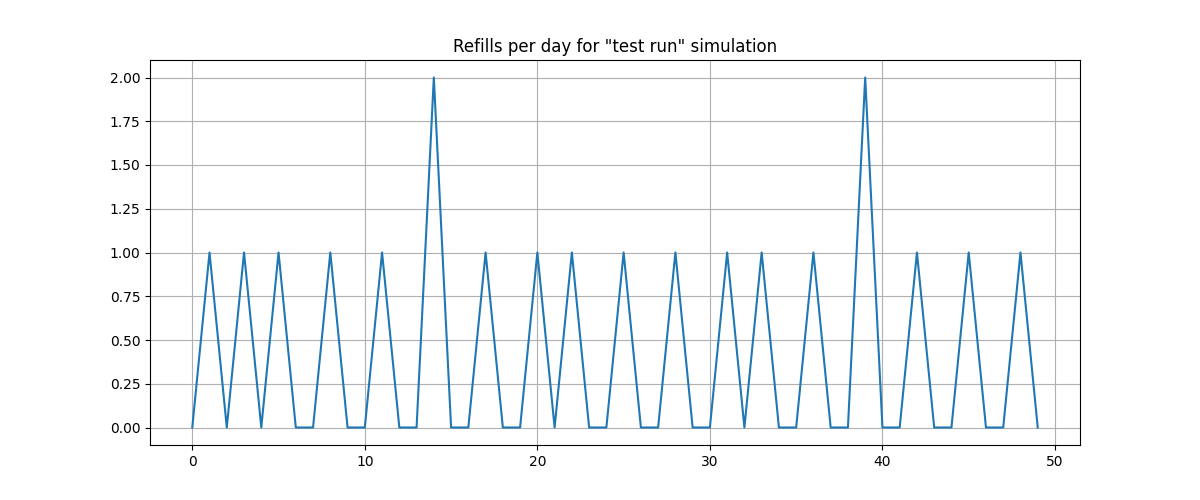

In [21]:
print(f'Total top ups for simulations: {sum(sim.refills_per_day)}')
sim.plot_stat('refills_per_day')

## Sort of economic model

In [22]:
interest_rate = 0.03
trip_cost = 500

def calc_utility(sim: Simulation, *, interest_rate: float, trip_cost: float) -> float:
    expenses = sum(sim.refills_per_day) * trip_cost + np.mean(sim.total_inventory_cost)/365 * len(sim.total_inventory_cost) * interest_rate
    profits = sum(sim.profit)[0]
    revenue = profits - expenses
    return revenue

In [23]:
calc_utility(sim, interest_rate=interest_rate, trip_cost=trip_cost)

105151.46301369864

# Parameters Optimization

## Best strategy params for given VM

In [31]:
# model set up

local_time = SimulationTime()

# -- Locations --

low_traffic_loc = Location('boring place', traffic_conf_interval=(3, 10))
high_traffic_loc = Location('railroad', traffic_conf_interval=(20, 40))

# -- Products --

PRODUCTS = pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('papa_beer', 40),
    ('water', 30),
    ('water', 30),
])

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('mama_beer', 40),
    ('baby_beer', 40),
    ('water', 30),
])


# -- strategies -- 

strategy = FillUpAllExistingToMaxOnMinLevel('test_one', min_levels={
    'papa_beer': 10,
    'mama_beer': 10,
    'baby_beer': 10,
    'water'    : 10,      
})

In [26]:
grid = [[*range(0, 50, 15)]]
product_ranges = dict(zip(PRODUCTS.name.to_list(), grid * PRODUCTS.shape[1]))
extra = {'how_many_should_hit_min': [1, 3]}
tuned_parameters = {**product_ranges, **extra}
tuned_parameters

{'papa_beer': [0, 15, 30, 45],
 'mama_beer': [0, 15, 30, 45],
 'baby_beer': [0, 15, 30, 45],
 'water': [0, 15, 30, 45],
 'how_many_should_hit_min': [1, 3]}

In [52]:
sim = Simulation(
    'test_run',
    products=PRODUCTS,
    VMs=[vm2],
    STGs={vm2: strategy},
    local_time=local_time,
    cycles=50
)

In [53]:
gs = GridSearch(
    sim=sim,
    param_grid=tuned_parameters,
    scoring_function=partial(calc_utility, interest_rate=interest_rate, trip_cost=trip_cost)
)

In [54]:
gs.calc_scores()

In [55]:
gs.scores

{'0-1-0-0-0': 75039.26712328767,
 '0-1-0-0-15': 76799.3493150685,
 '0-1-0-0-30': 80110.05205479452,
 '0-1-0-0-45': 78289.79315068493,
 '0-1-0-15-0': 85391.32191780822,
 '0-1-0-15-15': 80530.43835616438,
 '0-1-0-15-30': 76029.10684931507,
 '0-1-0-15-45': 75869.22602739726,
 '0-1-0-30-0': 79970.45479452054,
 '0-1-0-30-15': 80880.5287671233,
 '0-1-0-30-30': 81290.60273972602,
 '0-1-0-30-45': 81490.75068493151,
 '0-1-0-45-0': 78929.95342465753,
 '0-1-0-45-15': 76139.76849315068,
 '0-1-0-45-30': 82700.8493150685,
 '0-1-0-45-45': 77959.81369863014,
 '0-1-15-0-0': 86032.02465753425,
 '0-1-15-0-15': 82841.10821917807,
 '0-1-15-0-30': 75829.04520547946,
 '0-1-15-0-45': 75539.17671232877,
 '0-1-15-15-0': 81290.5904109589,
 '0-1-15-15-15': 79860.3191780822,
 '0-1-15-15-30': 78009.86712328767,
 '0-1-15-15-45': 75389.29589041095,
 '0-1-15-30-0': 81100.43013698631,
 '0-1-15-30-15': 77489.51780821919,
 '0-1-15-30-30': 77689.56301369863,
 '0-1-15-30-45': 77849.46438356164,
 '0-1-15-45-0': 79469.969863